In [ ]:
!pip install yfinance pandas tensorflow

In [ ]:
!pip install numpy==1.26.4

In [ ]:
!pip install pandas_ta --upgrade

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas_ta as pta

In [ ]:
tickers = ["HD", "MCD", "LOW", "TJX", "SBUX", "NKE", "MAR", "CMG", "TGT"]
start_date = "2022-01-01"
end_date = "2024-12-31"

stock_data = {}

# 데이터 수집
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust=False, progress=False)
    df = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].dropna()
    stock_data[ticker] = df

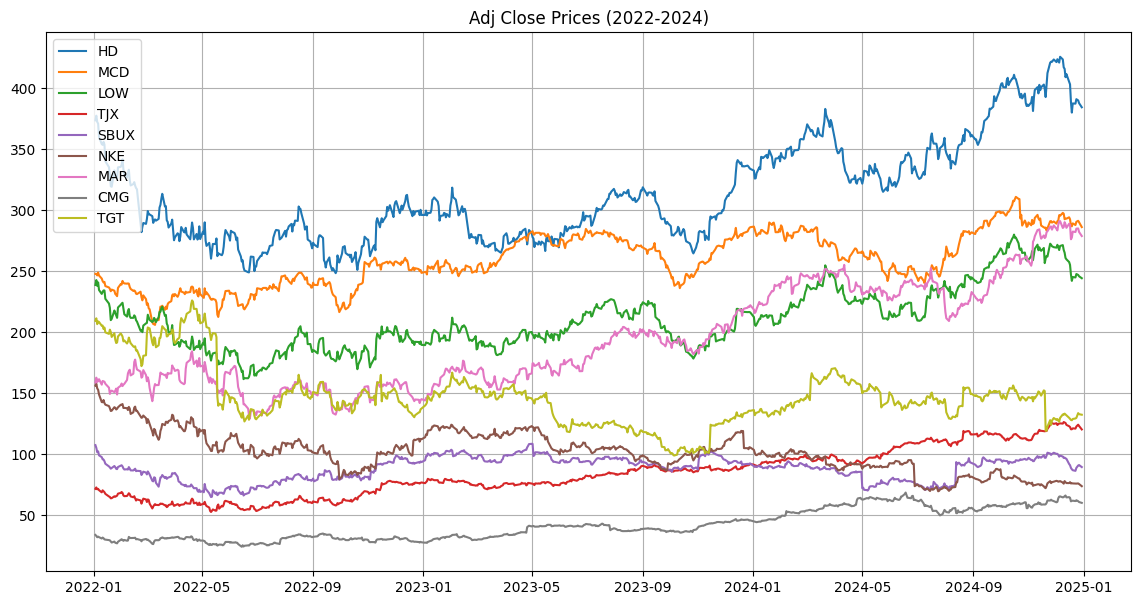

In [ ]:
# 1. 주가 차트 시각화
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(stock_data[ticker]["Adj Close"], label=ticker)
plt.title("Adj Close Prices (2022-2024)")
plt.legend()
plt.grid(True)
plt.show()

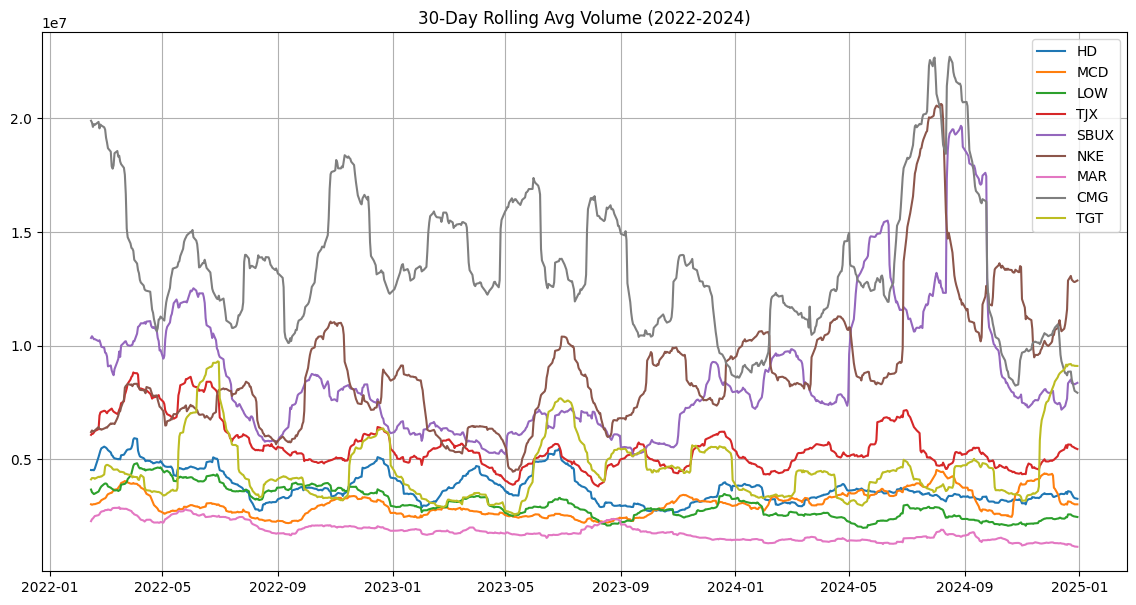

In [ ]:
# 2. 종목별 거래량 추이 시각화 (30일 이동평균)
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(stock_data[ticker]["Volume"].rolling(30).mean(), label=ticker)
plt.title("30-Day Rolling Avg Volume (2022-2024)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-5-3398162026.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = stock_data[ticker]["Adj Close"].resample("M").ffill().pct_change()
/tmp/ipython-input-5-3398162026.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = stock_data[ticker]["Adj Close"].resample("M").ffill().pct_change()
/tmp/ipython-input-5-3398162026.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = stock_data[ticker]["Adj Close"].resample("M").ffill().pct_change()
/tmp/ipython-input-5-3398162026.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = stock_data[ticker]["Adj Close"].resample("M").ffill().pct_change()
/tmp/ipython-input-5-3398162026.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = stock_data[t

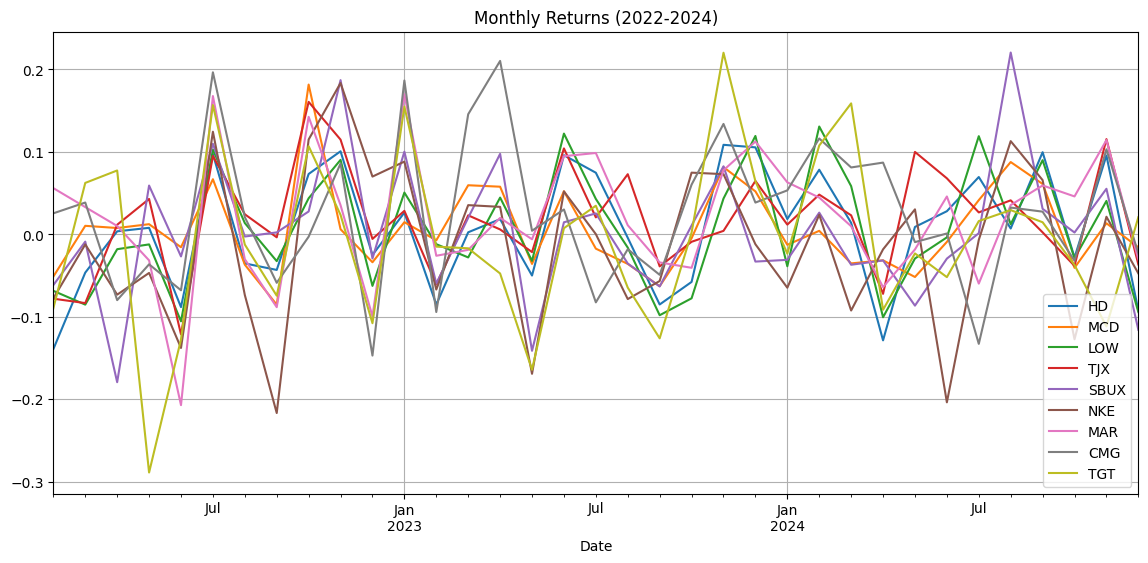

In [ ]:
# 3. 월간 수익률 비교
monthly_returns = pd.DataFrame()
for ticker in tickers:
    df = stock_data[ticker]["Adj Close"].resample("M").ffill().pct_change()
    monthly_returns[ticker] = df
monthly_returns.dropna().plot(figsize=(14, 6), title="Monthly Returns (2022-2024)")
plt.grid(True)
plt.show()

In [ ]:
# 4. 결측치 확인
for ticker, df in stock_data.items():
    print(f"{ticker}: {df.isnull().sum().sum()} missing values")

HD: 0 missing values
MCD: 0 missing values
LOW: 0 missing values
TJX: 0 missing values
SBUX: 0 missing values
NKE: 0 missing values
MAR: 0 missing values
CMG: 0 missing values
TGT: 0 missing values


Outlier Detection (Z-score > 3) and Visualization:

--- Processing HD ---
HD: 8 outliers / 총 751일


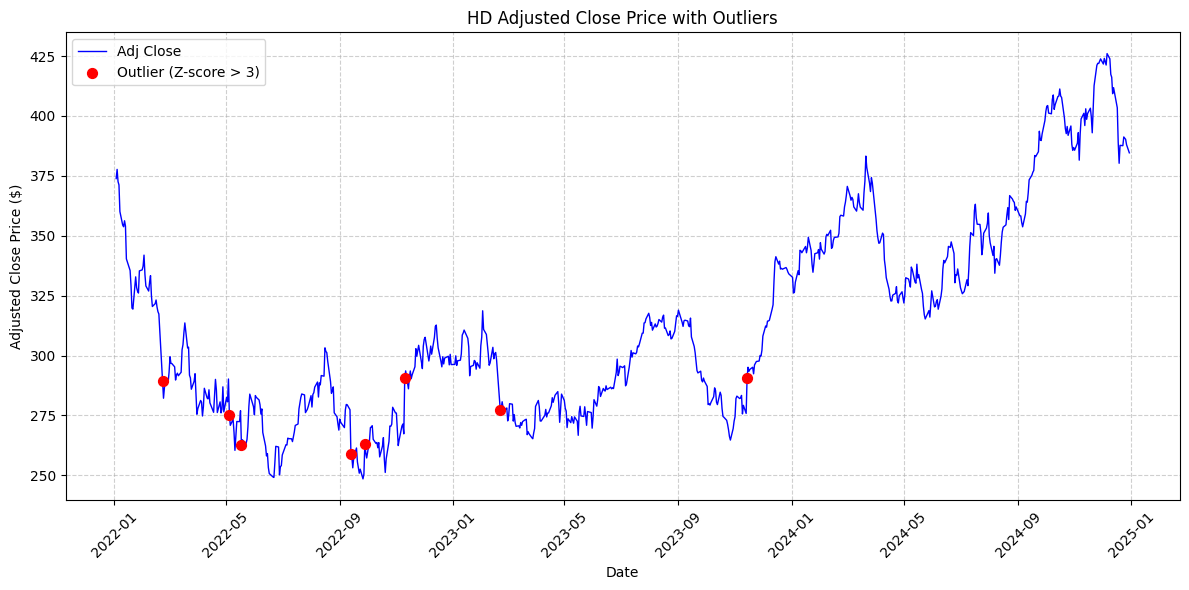


--- Processing MCD ---
MCD: 10 outliers / 총 751일


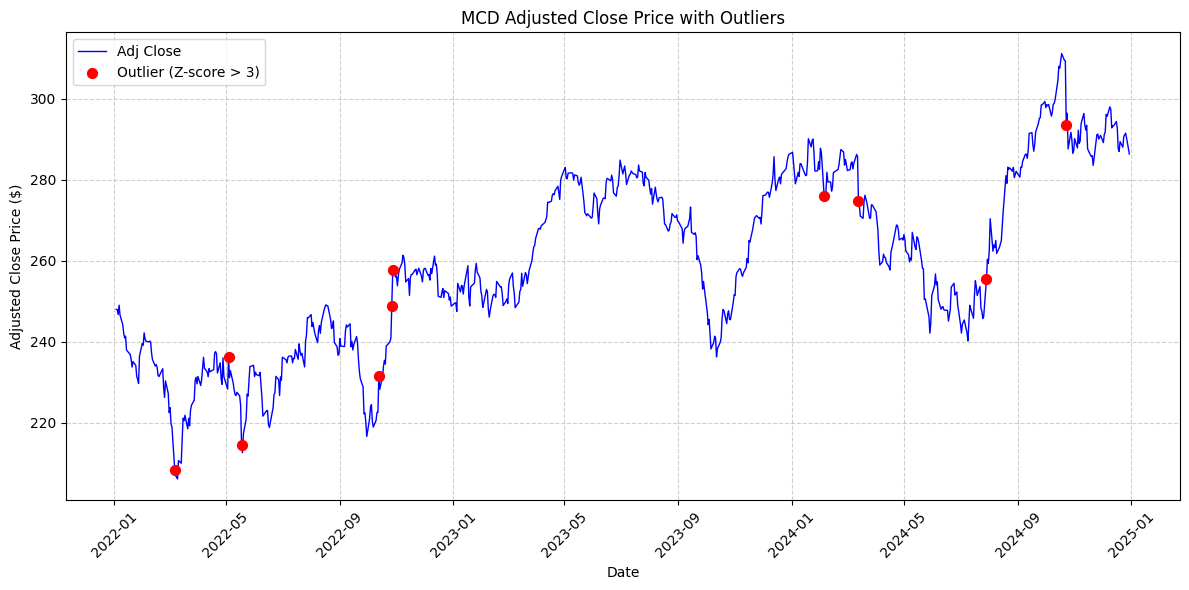


--- Processing LOW ---
LOW: 7 outliers / 총 751일


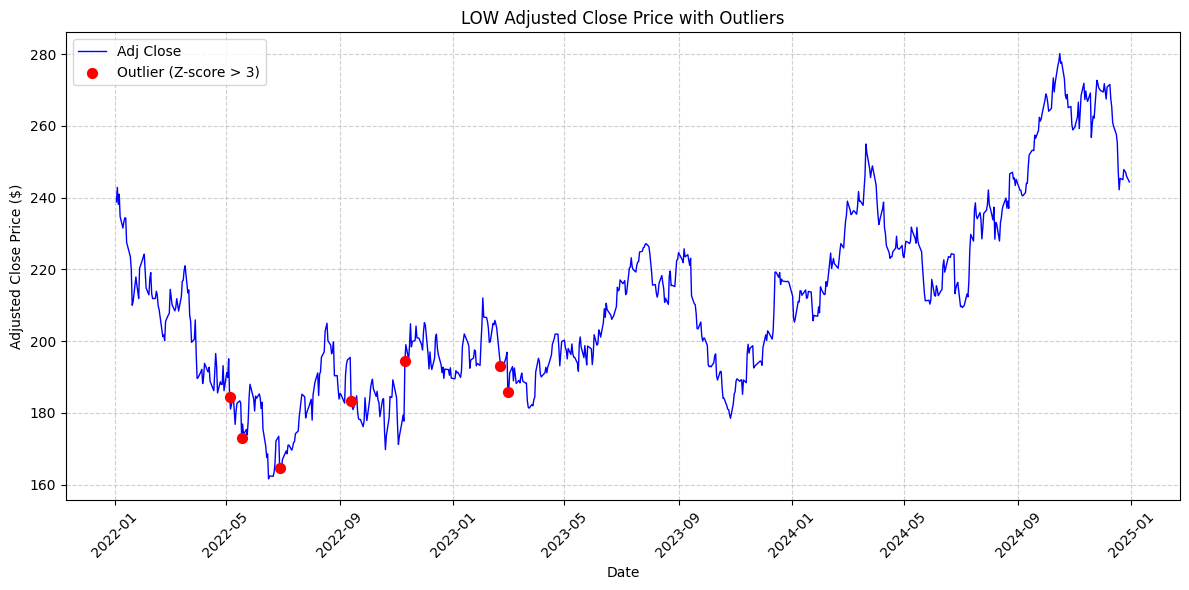


--- Processing TJX ---
TJX: 13 outliers / 총 751일


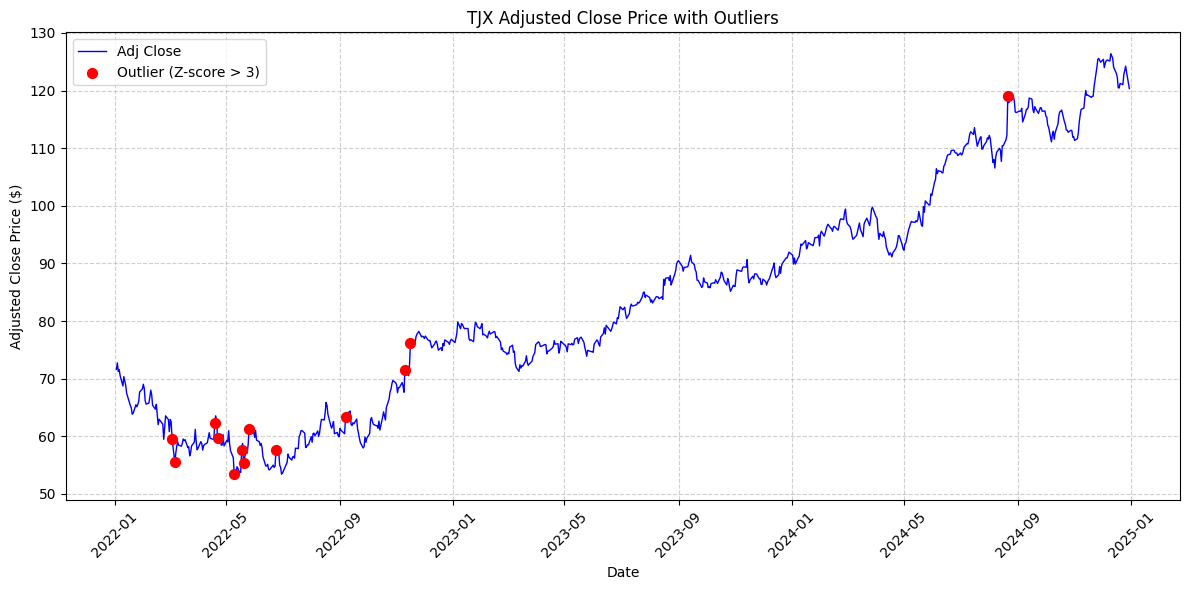


--- Processing SBUX ---
SBUX: 9 outliers / 총 751일


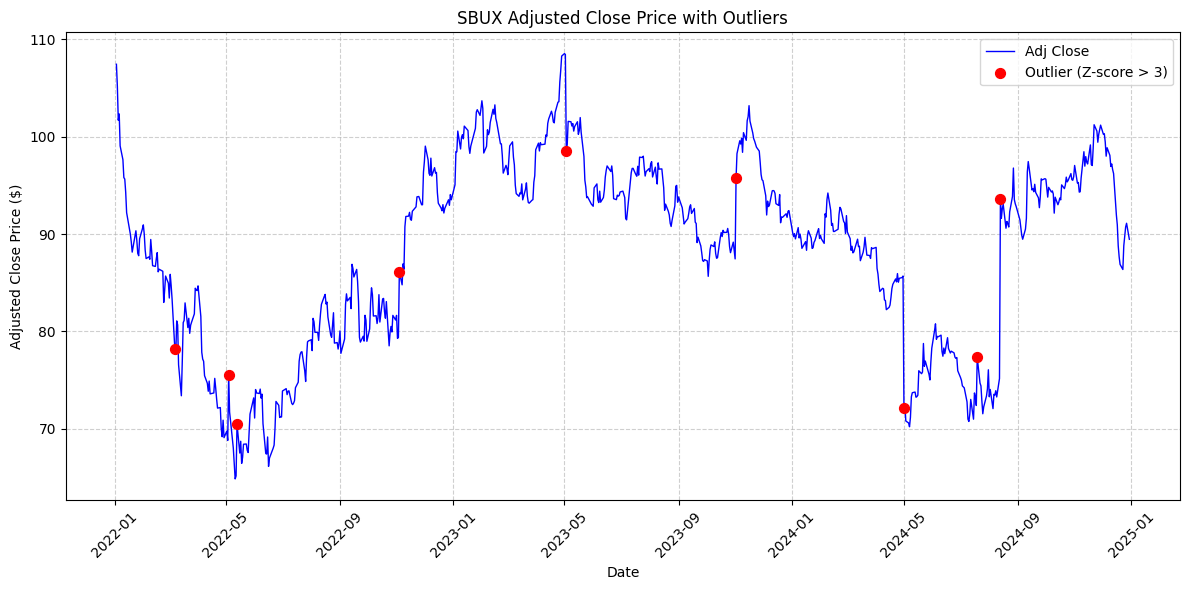


--- Processing NKE ---
NKE: 11 outliers / 총 751일


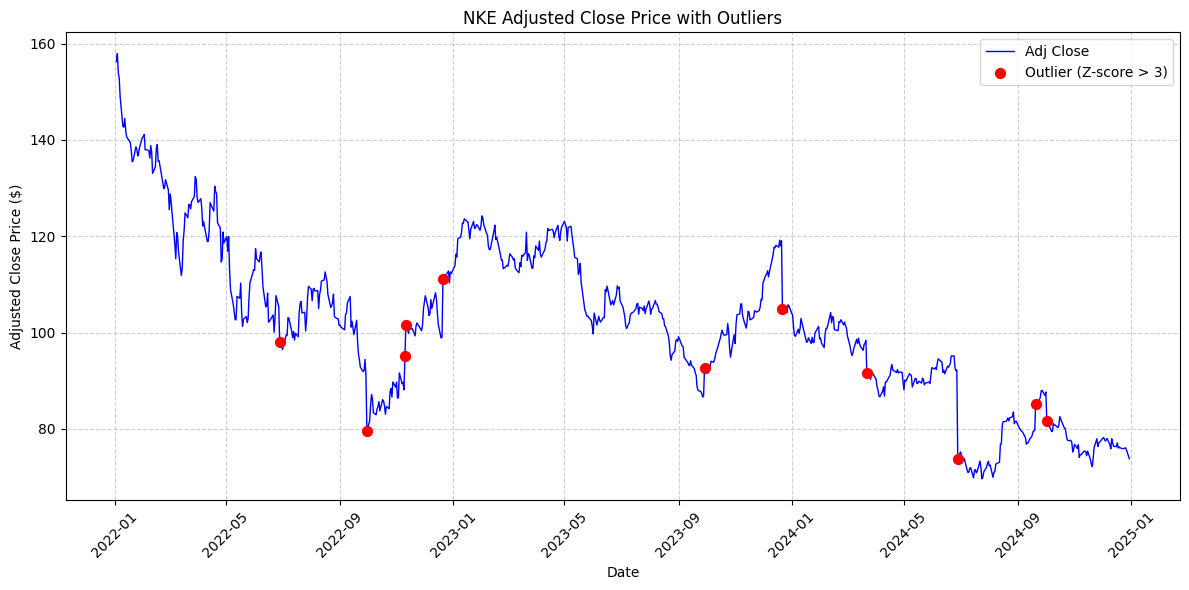


--- Processing MAR ---
MAR: 11 outliers / 총 751일


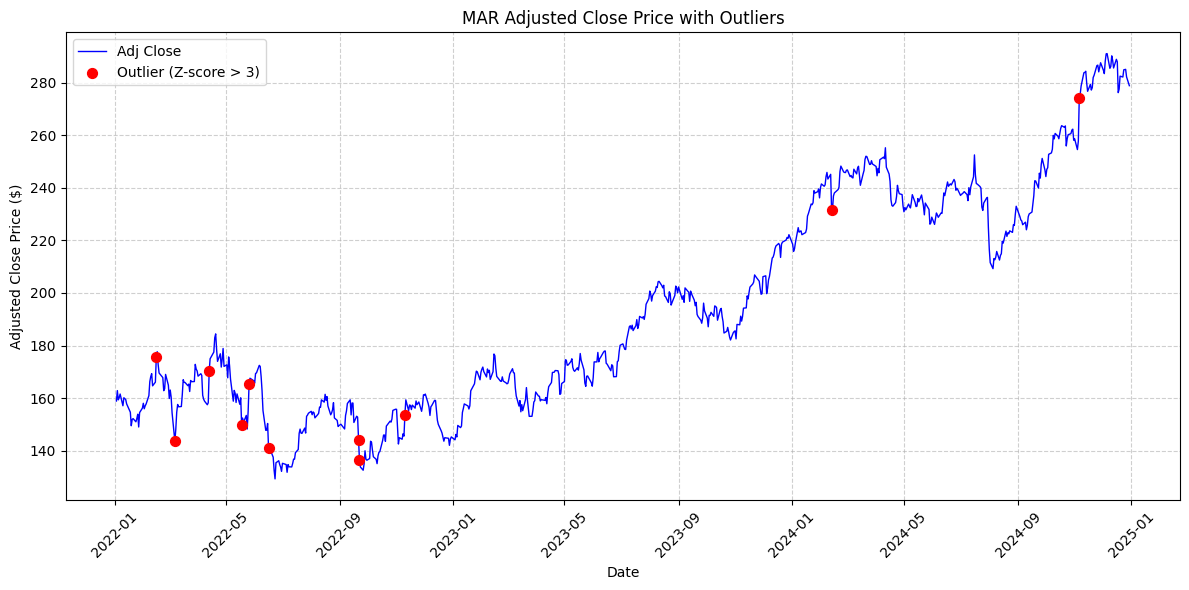


--- Processing CMG ---
CMG: 14 outliers / 총 751일


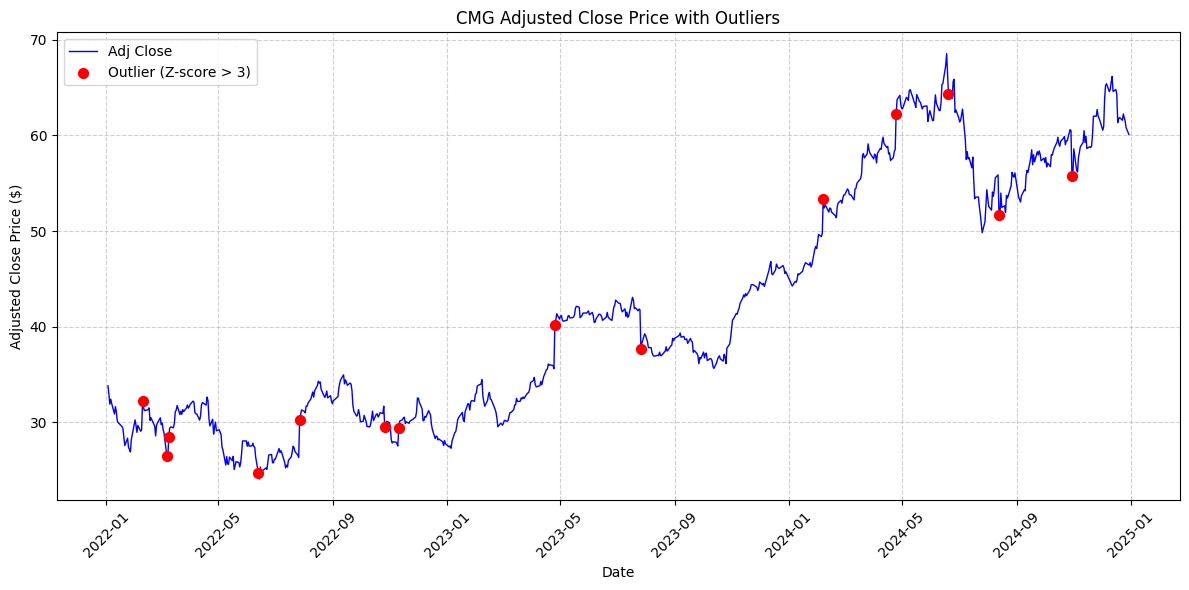


--- Processing TGT ---
TGT: 9 outliers / 총 751일


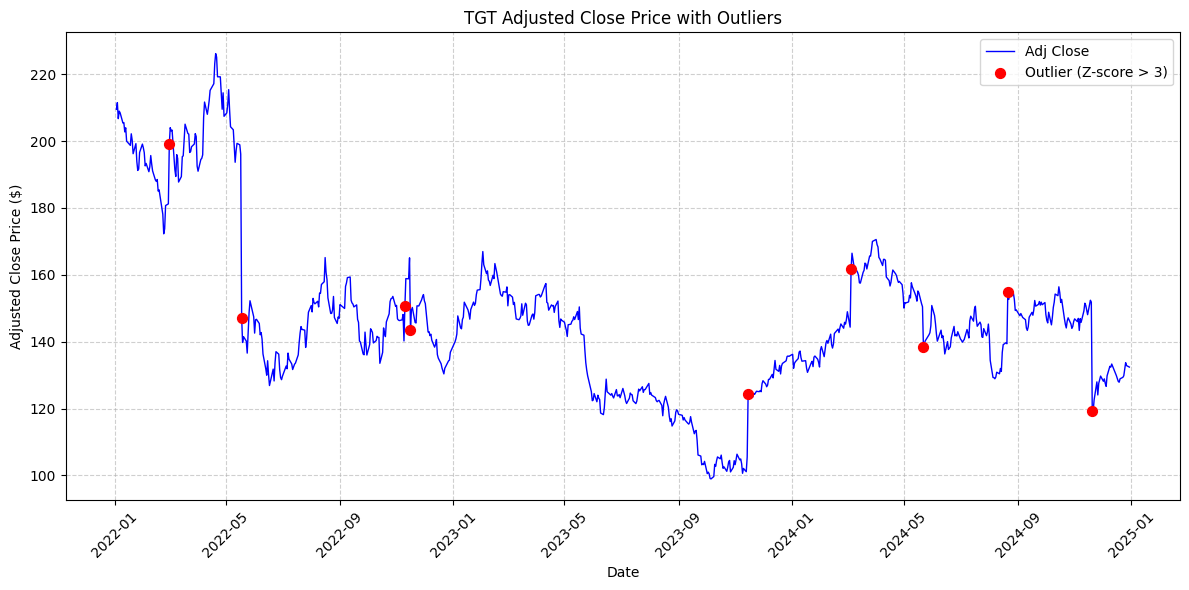

In [ ]:
# 5. 급등/급락 구간 (Z-score 기반 이상치 탐지) 및 시각화
print("Outlier Detection (Z-score > 3) and Visualization:")
for ticker in tickers:
    print(f"\n--- Processing {ticker} ---")

    # 현재 티커의 DataFrame 가져오기
    if ticker not in stock_data:
        print(f"{ticker}: stock_data에 해당 티커의 데이터가 없습니다.")
        continue
    df = stock_data[ticker] # 해당 티커의 데이터를 df에 할당
    adj_close_series = df['Adj Close']
    adj_close_series = adj_close_series.iloc[:, 0] # 첫 번째 컬럼을 Series로 사용

    # 수익률 계산
    returns = adj_close_series.pct_change().dropna()
    std_val = returns.std() # 표준편차

    # Z-score 계산 및 이상치 식별
    z_scores = (returns - returns.mean()) / std_val
    outliers = returns[np.abs(z_scores) > 3]
    print(f"{ticker}: {len(outliers)} outliers / 총 {len(returns)}일")

    # 시각화
    if not outliers.empty:
        # 이상치가 발생한 날짜 추출
        outlier_dates = outliers.index
        # 원본 주가 데이터에서 이상치 날짜에 해당하는 'Adj Close' 가격 추출
        outlier_prices = adj_close_series.loc[outlier_dates]

        plt.figure(figsize=(12, 6))
        plt.plot(adj_close_series.index, adj_close_series, label='Adj Close', color='blue', linewidth=1.0)

        # 이상치 지점(날짜, 가격)에 빨간색 점(scatter)으로 표시
        plt.scatter(outlier_dates, outlier_prices, color='red', label='Outlier (Z-score > 3)', s=50, zorder=5)

        # 그래프 제목 및 라벨 설정
        plt.title(f"{ticker} Adjusted Close Price with Outliers")
        plt.xlabel("Date")
        plt.ylabel("Adjusted Close Price ($)")
        plt.legend() # 범례 표시
        plt.xticks(rotation=45) # x축 날짜 라벨 회전
        plt.grid(True, linestyle='--', alpha=0.6) # 그리드 추가
        plt.tight_layout() # 그래프 요소들이 겹치지 않게 자동 조정
        plt.show() # 그래프 보여주기
    else:
        print(f"{ticker}: 시각화할 이상치가 없습니다.")